$$ \LaTeX \text{ command declarations here.}
\newcommand{\R}{\mathbb{R}}
\renewcommand{\vec}[1]{\mathbf{#1}}
\newcommand{\X}{\mathcal{X}}
\newcommand{\D}{\mathcal{D}}
\newcommand{\G}{\mathcal{G}}
\newcommand{\L}{\mathcal{L}}
\newcommand{\X}{\mathcal{X}}
\newcommand{\Parents}{\mathrm{Parents}}
\newcommand{\NonDesc}{\mathrm{NonDesc}}
\newcommand{\I}{\mathcal{I}}
\newcommand{\dsep}{\text{d-sep}}
\newcommand{\Cat}{\mathrm{Categorical}}
\newcommand{\Bin}{\mathrm{Binomial}}
$$

In [3]:
from __future__ import division

# scientific
%matplotlib inline
from matplotlib import pyplot as plt;
import matplotlib as mpl;
import numpy as np;
import sklearn as skl;
import sklearn.datasets;
import sklearn.cluster;
import sklearn.mixture;

# ipython
import IPython;

# python
import os;
import random;

#####################################################

# image processing
import PIL;

# trim and scale images
def trim(im, percent=100):
    print("trim:", percent);
    bg = PIL.Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = PIL.ImageChops.difference(im, bg)
    diff = PIL.ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        x = im.crop(bbox)
        return x.resize(((x.size[0]*percent)//100, (x.size[1]*percent)//100), PIL.Image.ANTIALIAS);


#####################################################

# daft (rendering PGMs)
import daft;

# set to FALSE to load PGMs from static images
RENDER_PGMS = True;

# decorator for pgm rendering
def pgm_render(pgm_func):
    def render_func(path, percent=100, render=None, *args, **kwargs):
        print("render_func:", percent);
        # render
        render = render if (render is not None) else RENDER_PGMS;
        
        if render:
            print("rendering");
            # render
            pgm = pgm_func(*args, **kwargs);
            pgm.render();
            pgm.figure.savefig(path, dpi=300);
            
            # trim
            img = trim(PIL.Image.open(path), percent);
            img.save(path, 'PNG');
        else:
            print("not rendering");
        
        # error
        if not os.path.isfile(path):
            raise Exception("Error:  Graphical model image %s not found.  You may need to set RENDER_PGMS=True." % path);
        
        # display
        return IPython.display.Image(filename=path);#trim(PIL.Image.open(path), percent);
    
    return render_func;

######################################################

# EECS 545:  Machine Learning

## Lecture 18:  Inference & Applications of PGMs

- Instructor:  **Jacob Abernethy**
- Date:  March 14, 2016

*Lecture Exposition:*  Benjamin Bray

## References

- **[MLAPP]** Murphy, Kevin. [*Machine Learning:  A Probabilistic Perspective*](https://mitpress.mit.edu/books/machine-learning-0).  2012.
- **[PRML]** Bishop, Christopher.  [*Pattern Recognition and Machine Learning*](http://research.microsoft.com/en-us/um/people/cmbishop/prml/).  2006.
- **[Koller & Friedman 2009]** Koller, Daphne and Nir Friedman.  [*Probabilistic Graphical Models*](https://mitpress.mit.edu/books/probabilistic-graphical-models)

### Graphical Models: Wrap-Up

We've just barely scratched the surface of what **probabilistic graphical models** have to offer.
- Bayesian Networks
- Mixture Models
- Hidden Markov Models
- Latent Variable Models & Expectation-Maximization

This lecture will be a grab-bag of some of the things we missed.

> Accordingly, we won't test you on the details.  

### Graphical Models:  Related Courses

These courses are being offered next semester:
- **IOE 591**, [Bayesian Data Analysis](https://d1b10bmlvqabco.cloudfront.net/attach/iizaobacnl55nb/hku8ttycli2/ilxshlclzteu/IOE591_flyer.pdf)
- **EECS 592**, Advanced Artificial Intelligence

The following courses have been offered in the past:
- **STATS 601**, Analysis of Multivariate and Categorical Data
- **EECS 598**, [Probabilistic Graphical Models in Vision and Beyond](http://web.eecs.umich.edu/~jjcorso/t/598W15/)
- **STATS 700**, [Probabilistic Graphical Models](http://dept.stat.lsa.umich.edu/~xuanlong/courses/stat700-f09/)

### Graphical Models:  Other Resources

- **[Koller & Friedman 2009]** Koller, Daphne and Nir Friedman.  [*Probabilistic Graphical Models*](https://mitpress.mit.edu/books/probabilistic-graphical-models)
- **[Wainwright & Jordan 2008]** Wainwright, Martin, and Michael Jordan.  [Graphical Models, Exponential Families, and Variational Inference](https://www.eecs.berkeley.edu/~wainwrig/Papers/WaiJor08_FTML.pdf).  2008
- **Coursera,** [Probabilistic Graphical Models](https://www.coursera.org/course/pgm)

## Outline

- Undirected Graphical Models
    - Markov Random Fields
- Summary of Exact Inference
- Approximate Inference
    - Gibbs Sampling
    - Variational Inference
- Applications
    - Latent Dirichlet Allocation

# Undirected Graphical Models

> Uses material from **[MLAPP]** Chapter 19 and **[Koller & Friedman 2009]** Chapter 4

### Markov Random Fields:  Motivation

So far, we have talked only about **directed models**.
- Directed edges represent an underlying generative process.
- Formalizes independence properties between variables

In some cases, **undirected models** are more natural.
- In many applications, it's hard to assign a direction to the interactions between variables.
- Offer a different, sometimes simpler, perspective

### Markov Random Fields:  Motivation

Consider the problem of modeling pixels in an image.
- One random variable $X_{ij}$ per pixel $(i,j)$ in the image.
- Intensity values of neighboring pixels are *locally* correlated

How can we represent this situation as a Bayesian network?
- Which directions do the arrows go?
- Which independence properties are desirable?

### Markov Random Fields:  Motivation

We could arbitrarily add directed edges, but this leads to strange independence structures.
- Below, $X_8$ is independent of all other variables given the colored nodes.

<img src="images/murphy-fig191a.png">


<span style="color:gray; font-size:10px; float:right">(Figure 19.1a from **[MLAPP]**)</span>

### Markov Random Fields:  Motivation

Since images have no natural "directionality", why bother with undirected edges?
- Now, $X_8$ is independent of all other variables given its immediate neighbors.  

<img src="images/murphy-fig191b.png">


<span style="color:gray; font-size:10px; float:right">(Figure 19.1b from **[MLAPP]**)</span>

### Markov Random Fields:  Parameterization

Directed models come with a natural topological ordering.
- Applying the chain rule yields a factorization.
- It is only necessary to store **conditional probability tables**

Undirected models have no natural ordering!
- Instead, we describe the model in terms of **factors** describing the local interactions between variables.

### Markov Random Fields:  Factors

Let $\mathbf{D}$ be a set of random variables.  A **factor** is a function $\phi : \mathrm{Val}(\mathbf{D}) \mapsto \R$.
- where $\mathrm{Val}(\mathbf{D})$ is the set of possible configurations of the variables.
- where $\mathbf{D}$ is called the *scope* of $\phi$

> A factor assigns a real number to every possible configuration of the variables $\mathbf{D}$

### Markov Random Fields:  Factors

Probability distributions are *normalized* factors.
- $P(X_1,X_2,X_3)$ is a factor on $\mathbf{D}=(X_1,X_2,X_3)$
- $P(X | Y)$ is a factor on $\mathbf{D}=(X,Y)$

Other factors need not be normalized.  For example, $\phi(A,B)$ assigns high *affinity* to configurations where $A$ and $B$ agree:

<table>
<thead><th>$A$</th><th>$B$</th><th>$\phi(A,B)$</th></thead>
<tbody>
    <tr><td>0</td><td>0</td><td>100</td></tr>
    <tr><td>0</td><td>1</td><td>-50</td></tr>
    <tr><td>1</td><td>0</td><td>-50</td></tr>
    <tr><td>1</td><td>1</td><td>100</td></tr>
</tbody>
</table>

### Markov Random Fields:  Parameterization

Given a set of factors $\Phi=(\phi_1(\mathbf{D}_1), \phi_2(\mathbf{D}_2), \dots, \phi_K(\mathbf{D}_K))$, we can define a **Gibbs Distribution**,
    $$
    \begin{align}
    P_\Phi(X_1,\dots,X_n)
    &= \frac{1}{Z} \phi_1(\mathbf{D}_1) \phi_2(\mathbf{D}_2) \cdots \phi_K(\mathbf{D}_K) \\
    &= \frac{1}{Z} \exp\left[ \sum_{k=1}^K \log \phi_k(\mathbf{D}_k) \right]
    \end{align}
    $$
where $Z$ is a normalization constant.  Sometimes log-potentials are referred to as **energies** associated with each configuration of variables.

> This model was stolen from physicists :)

### Markov Random Fields:  Texture Modeling

Suppose we have a **pairwise Markov Random Field** over binary pixels.
- *Binary:* Each pixel is either $-1$ (black) or $1$ (white)
- *Pairwise:* Only model interactions between directly neighboring pixels.

Define the **energy function**, summing over all edges $(i,j)$:
$$
U(\X) = -\beta \sum_{(i,j)} x_i x_j \qquad (\beta > 0)
$$

### Markov Random Fields:  Texture Modeling

Then, the probability of an image is
$$
P(\X)
= \frac{1}{Z} \exp[-U(\X)]
= \frac{1}{Z} \exp\left[-\beta \sum_{(i,j)} x_i x_j \right]
$$

The *affinity parameter* $\beta > 0$ determines how much we want neighboring pixels to agree with each other.
- Low energy = High probability = Neighbors Agree
- High energy = Low probability = Neighbors Disagree

### Markov Random Fields:  Texture Modeling

Using Gibbs Sampling (later!) we can generate image samples! (low $\beta$)

<img src="images/mrf-texture-1.png">

### Markov Random Fields:  Texture Modeling

Using Gibbs Sampling (later!) we can generate image samples! (high $\beta$)

<img src="images/mrf-texture-2.png">

### Markov Random Fields:  Texture Modeling

We can also model more complex interactions between pixels.
- Force vertical neighbors to agree, horizontal neighbors to disagree.
- Rather than taking direct neighbors, look at a *window* around each pixel.
- Learn different $\beta$ values for different regions of the image.

### Markov Random Fields:  Texture Synthesis

We can learn to sample large textures from a small starting seed:

<img src="images/mrf-texture-3.png">

<span style="color:gray; font-size:10px; float:right">(Example taken from Efros & Leung, [Texture Synthesis by Non-Parametric Sampling](http://ieeexplore.ieee.org.proxy.lib.umich.edu/stamp/stamp.jsp?tp=&arnumber=790383))</span>

### Markov Random Fields:  Texture Synthesis

The same algorithm can even be applied to text!

<img src="images/mrf-texture-4.png">

<span style="color:gray; font-size:10px; float:right">(Example taken from Efros & Leung, [Texture Synthesis by Non-Parametric Sampling](http://ieeexplore.ieee.org.proxy.lib.umich.edu/stamp/stamp.jsp?tp=&arnumber=790383))</span>

### Undirected Models:  Other Applications

Undirected models are incredibly useful for probabilistic modeling.
- Image Processing
    - Segmentation, Denoising
- Natural Language Processing
    - Named entity recognition
    - Parsing
    - Computational Humor
- Maximum entropy models (related to exponential family)
- Conditional random fields (discriminative model)
- Deep learning

# Inference in Graphical Models

> Uses material from **[MLAPP]** Chapters 20, 21

### Inference in Graphical Models

**Inference**:  Estimate hidden variables $Z$ from observed variables $X$.
$$
P(Z | X,\theta) = \frac{P(X,Z | \theta)}{P(X|\theta)}
$$

- Denominator $P(X|\theta)$ is sometimes called the probability of the **evidence**.
- Occasionally we care only about a subset of the hidden variables, and marginalize out the rest.

### Inference:  Examples

We have already described the inference procedure for simple models:

- Expectation Maximization
- Mixture Models
- Hidden Markov Models

> Given an arbitrary directed or undirected graph, can we systematically perform inference?

## Exact Inference

> Uses material from **[MLAPP]** Chapter 20

### Exact Inference

We can recover $P(Z | X,\theta)$ exactly when the hidden variables $Z$ are **discrete**.
- Belief Propagation
- Variable Elimination
- Junction Tree

Many exact inference algorithms can be seen as a generalization of the **fowards-backwards algorithm** for HMMs.
> Unfortunately, they have undesirable time and space complexity properties.

### Exact Inference:  HMMs

Recall that a **Hidden Markov Model** is a chain-structured directed model:

In [4]:
@pgm_render
def pgm_hmm():
    pgm = daft.PGM([7, 7], origin=[0, 0])

    # Nodes
    pgm.add_node(daft.Node("Z1", r"$Z_1$", 1, 3.5))
    pgm.add_node(daft.Node("Z2", r"$Z_2$", 2, 3.5))
    pgm.add_node(daft.Node("Z3", r"$\dots$", 3, 3.5, plot_params={'ec':'none'}))
    pgm.add_node(daft.Node("Z4", r"$Z_T$", 4, 3.5))

    pgm.add_node(daft.Node("x1", r"$X_1$", 1, 2.5, observed=True))
    pgm.add_node(daft.Node("x2", r"$X_2$", 2, 2.5, observed=True))
    pgm.add_node(daft.Node("x3", r"$\dots$", 3, 2.5, plot_params={'ec':'none'}))
    pgm.add_node(daft.Node("x4", r"$X_T$", 4, 2.5, observed=True))


    # Add in the edges.
    pgm.add_edge("Z1", "Z2", head_length=0.08)
    pgm.add_edge("Z2", "Z3", head_length=0.08)
    pgm.add_edge("Z3", "Z4", head_length=0.08)

    pgm.add_edge("Z1", "x1", head_length=0.08)
    pgm.add_edge("Z2", "x2", head_length=0.08)
    pgm.add_edge("Z4", "x4", head_length=0.08)
    
    return pgm;

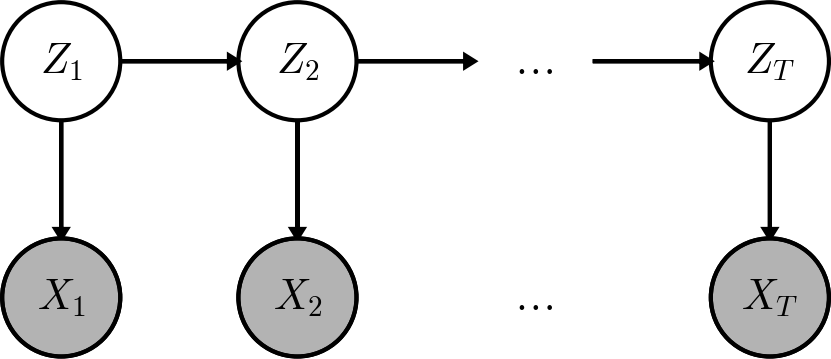

In [5]:
%%capture
pgm_hmm("images/pgm/hmm.png")

### Exact Inference:  HMMs

We used the **fowards-backwards algorithm** to find $P(Z_t | \X,\theta)$.
- We split the graph at $Z_t$
- Performed the **foward algorithm** to propagate information from the start state *forwards* to $Z_t$
- Performed the **backward algorithm** to propagate information *backwards* to $Z_t$

### Belief Propagation:  From Chains to Trees

The **Belief Propagation** algorithm generalizes the forwards-backwards algorithm from chains to tree-structured graphs.
- *Idea:*  Every path from the root node to a leaf node is a chain!

> Let's do some hand-waving...

### Belief Propagation:  Collect-to-Root Phase

Much like before, we split the tree at node $t$ and propagate evidence upwards:

<img src="images/murphy-fig201a.png">

<span style="color:gray; font-size:10px; float:right">(Figure 20.1a from **[MLAPP]**)</span>

### Belief Propagation:  Distribute-from-Root Phase

Next, we propagate the collected evidence back down the tree:

<img src="images/murphy-fig201b.png">


<span style="color:gray; font-size:10px; float:right">(Figure 20.1b from **[MLAPP]**)</span>

### Junction Tree:  From Trees to Graphs

The **Junction Tree** algorithm generalizes Belief Propagation from trees to arbitary graphs.

> See **[MLAPP]** or **[Koller & Friedman 2009]** for details.

### Exact Inference:  Summary

Exact inference is possible in discrete graphical models.
- Unfortunately, algorithms to do so are ugly and complicated.
- Moreover, exact inference is NP-Hard, so these algorithms are very inefficient.
- Incapable of dealing with general, continuous distributions.

Fortunately, **approximate inference** works well in practice.

## Approximate Inference

> Uses material from **[MLAPP]** Chapter 21 and [MLSS 2009](http://videolectures.net/site/normal_dl/tag=50736/mlss09uk_murray_mcmc.pdf)

### Approximate Inference:  Intro

Exact inference is too difficult, so we turn to **approximate inference**.
- Theory is lacking--no guarantees about accuracy or runtime
- However, they seem to work well in practice.
- Capable of handling continuous variables!

The two most common methods are
- **Markov Chain Monte Carlo:** Estimate $P(Z|X,\theta)$ by sampling from it!
- **Variational Inference:** Cast inference as a deterministic optimization problem.

### Integration is Hard

In general, we want to find $p(X|Y)$ for some variables $X$ and $Y$.  Using Bayes' Rule,
    $$p(y|x)= \frac{p(x|y)p(y)}{p(x)}= \frac{p(x|y)p(y)}{\int_Y p(x|y)p(y)\, dy}$$
Usually, the hard part is evaluating the normalization integral,
    $$
    \int_Y p(x|y)p(y)\, dy
    $$
    
> **Key Point:** Many inference problems can be reduced to the problem of *evaluating an integral*.

### Monte Carlo Integration

Suppose we wish to evaluate $\int_X f(x) p(x) \, dx$, where
- $f(x)$ is an arbitrary function
- $\pi(x)$ is a probability distribution

We can express this as an expectation, with $X \sim p(X)$,
    $$
    \int_X f(x) p(x) \, dx = E_p[f(X)]
    $$

### Monte Carlo Integration

We can approximate any expectation by averaging over samples $X_1,\dots,X_N \stackrel{iid}{\sim} p(X)$,
    $$
    \int_X f(x) p(x) \, dx
    = E_p[f(X)] \approx \bar{f}_N
    = \frac{1}{N} \sum_{n=1}^N f(x_n)
    $$
    
> **Key Point:** We can reduce any integration problem to a *sampling problem*.

### Example:  Dumb Approximation of $\pi$

We can express $\pi$ as an integral over the unit circle $C$, which has area $\pi r^2 = 1$.

$$
\pi
= \int_{\R^2} \mathbb{I}_C(x) \, dx
= \int_{[-1,1]\times[-1,1]} \mathbb{I}_C(x) \,dx
$$

Let $p(x)=\frac{1}{4}$ be the uniform distribution on the square of size $2$ centered at the origin.  Then,
$$
\pi
= 4\; \int_{[-1,1]\times[-1,1]} \mathbb{I}_C(x) p(x) \,dx \approx E_p[4\cdot \mathbb{I}_C(X) ]
$$

### Example:  Dumb Approximation of $\pi$

Therefore, we can estimate $\pi$ by drawing samples uniformly from the square $[-1,1] \times [-1,1]$ and computing the fraction of samples that fall within the unit circle $C$!
> This method is **terrible** and requires tons of samples.  

$$
\frac{\text{Area of Circle}}{\text{Area of Square}}
= \frac{\pi r^2}{4r^2} = \frac{\pi}{4}
$$

### Example:  Dumb Approximation of $\pi$

In [66]:
def estimate_pi(n):
    # draw samples
    samples = np.random.random((2,n)) * 2 - 1;
    # separate samples inside/outside circle
    r = np.sum(samples**2, axis=0);
    inside = samples[:,r < 1];
    outside = samples[:,r >= 1];
    # estimate pi
    return inside.shape[1] / n * 4;

def estimate_pi_plot(n):
    # draw samples
    samples = np.random.random((2,n)) * 2 - 1;
    # separate samples inside/outside circle
    r = np.sum(samples**2, axis=0);
    inside = samples[:,r < 1];
    outside = samples[:,r >= 1];
    # estimate pi
    pi_estimate = inside.shape[1] / n * 4;

    # plot
    plt.figure(figsize=(6,6))
    plt.plot(inside[0,:], inside[1,:], "rx");
    plt.plot(outside[0,:], outside[1,:], "bx");
    plt.axis("equal");
    plt.title(r"$\pi \approx %0.2f$ from %d samples" % (pi_estimate,n));

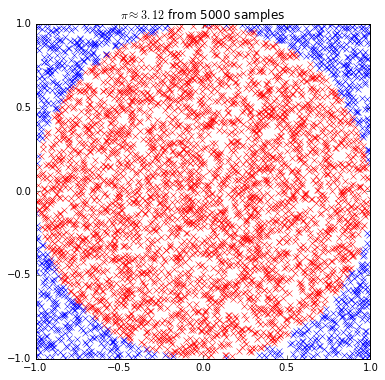

In [75]:
estimate_pi_plot(5000)

### Monte Carlo Integration:  Sampling

We can compute any integral $\int_X f(x)p(x) \, dx$ provided that we know how to sample from $p$.  Different methods have been devloped to sample from arbitrary distributions:
- Sampling from Inverse CDF
- Rejection Sampling
- Importance Sampling
- Particle Filtering

The most popular is **Markov Chain Monte Carlo**, which beats out the other methods in high-dimensional spaces.

### Markov Chain Monte Carlo

**Goal:** Draw samples from $P(X_1,\dots,X_N)$.
- Usually, $N$ is large, so $P$ is high-dimensional.

**Idea:** Construct a Markov Chain on the state space $\X$ whose *stationary distribution* is the target density.

> We will perform a (biased) random walk on the state space, such that the fraction of time we spend at each state $(x_1,\dots,x_N)$ is proportional to $p(x_1,\dots,x_N)$

### Markov Chain Monte Carlo

<img src="images/mcmc.png">

<span style="color:gray; font-size:10px; float:right">(Figure taken from [MLSS 2009 Slides](http://videolectures.net/site/normal_dl/tag=50736/mlss09uk_murray_mcmc.pdf))</span>

### MCMC:  Gibbs Sampling

Sample each variable in turn, conditioned on all the others.
- Assumes the **full conditionals** $p(x_k | \mathbf{x}_{-k})$ are known

<div style="margin: 10px; padding: 20px; border: 2px solid black">
<ol>
    <li>Initialize $\mathbf{x}^{0}=(x_1^0, x_2^0, \dots, x_N^0)$ randomly.</li>
    <li>For $k \in {1,\dots,N}$ in a random order,
        <ol>
            <li>Set $\mathbf{x}^{t+1} = \mathbf{x}^t$
            <li>Resample $x_k^{t+1} \sim p(x_k \mid \mathbf{x}_{-k}^t)$
        </ol></li>
</ol>
</div>

### MCMC:  Gibbs Sampling

<img src="images/bishop-fig1111.png">

<span style="color:gray; font-size:10px; float:right">(Figure 11.11 from **[PRML]**)</span>

### MCMC:  Summary

1. Inference can often be reduced to an integration problem.
2. Integration problems can be expressed as an expection.
3. Expectations can be approximated by averaging over samples.
4. **Inference can be reduced to a sampling problem.**

### MCMC:  Summary

Advantages:
- Easy to implement
- Works well in high dimensions
- Guaranteed to converge to the true distribution

Disadvantages:
- The Markov Chain may not **mix** fast enough
- Need lots of samples
- Convergence rate unknown

### Variational Inference

The goal of **variational inference** is to cast learning as an optimization problem.
- Want to estimate some distribution $p(x_1, \dots, x_n)$
- Approximate $p$ with a parametric family $\mathcal{Q} = \{q_\nu\}_\nu$ of simpler distributions.

Find the distribution in $\mathcal{Q}$ that is *closest* to $p$:
    $$
    \nu^* = \arg\min_\nu D_{KL}(q_\nu || p)
    $$

### Variational Expectation Maximization

Recall the **Expectation Maximization Algorithm**, where we chose $q_\vartheta(Z) = p(Z|\X,\vartheta)$.

<div style="margin:10px;padding:10px;border:2px solid black;">
<div>
**E-Step:** Compute a new lower bound on the observed log-likelihood,
    $$
    \vartheta_{t+1} 
    = \arg\min_\vartheta D_{KL}(q_\vartheta || p(Z|\X,\theta_t)
    = \theta_t
    $$
</div><div>
**M-Step:** Estimate new parameters by maximizing the bound.
    $$
    \theta_{t+1}
    = \arg\max_\theta \L(\vartheta_{t+1}, \theta)
    = \arg\max_\theta E_q[ \log p(\X,Z | \theta) ]
    $$
</div>
</div>

### Variational Expectation Maximization

**Problem:** What if the hidden posterior $P(Z|\X,\theta)$ is intractable?
- Expectation-Maximization no longer works.
- Now, our theoretical derivation comes in handy.

### Variational Expectation Maximization

**Idea:** Approximate the hidden posterior by a simpler distribution $q$.  In *mean-field variational inference*, we assume the hidden variables are completely independent:
    $$
    q_\vartheta(Z) = \prod_{k=1}^K q_k(Z_k | \vartheta)
    $$
    
> This is the same as removing all edges between latent variables in the corresponding graphical model.

### Variational Expectation Maximization

Next, we perform Expectation-Maximization as usual!
- Unfortunately, the E-Step is no longer trivial.
- We must optimize over the **variational parameters**.

Variational inference works well in practice.
- Converges to an approximate answer much more quickly than MCMC.

# Application:  Latent Dirichlet Allocation

> This was originally a homework problem, but you lucked out :)  See [**[Blei, Ng, and Jordan 2003]**](http://ai.stanford.edu/~ang/papers/nips01-lda.pdf) for details.

### Latent Dirichlet Allocation

**Latent Dirichlet Allocation** models documents as mixtures of latent *topics*.
- Makes the **bag-of-words** assumption.
- A **topic** is a probability distribution over words.
- Is a **mixed-membership** mixture model.  Each document expresses more than one topic with different *proportions*.

### LDA:  Generative Process

Given a set $\beta=(\beta_1,\dots,\beta_K)$ of $K$ topics and a fixed vocabulary, generate documents in the following way:

1. Choose topic proportions $\theta_d \sim \mathrm{Dirichlet}(\alpha)$
1. For each word $w_{dn}$,
    1. Choose a random topic $z_{dn}$ according to the weights $\theta_d$.
    1. Choose a random word $w_{dn}$ from topic $\beta_{z_{dn}}$

### LDA:  Intuitive View

<img src="images/lda-explained.png">


<span style="color:gray; font-size:10px; float:right">(Taken from [MLSS 2012 Slides](http://yosinski.com/mlss12/media/slides/MLSS-2012-Blei-Probabilistic-Topic-Models.pdf) by David Blei)</span>

### LDA:  Graphical Model

<img src="images/lda-pgm.png">

<span style="color:gray; font-size:10px; float:right">(Taken from [MLSS 2012 Slides](http://yosinski.com/mlss12/media/slides/MLSS-2012-Blei-Probabilistic-Topic-Models.pdf) by David Blei)</span>

### LDA:  Inference

Latent Dirichlet Allocation is arguably the simplest model that requires approximate inference.  It is often used as the "hello world" example when new inference techniques are introduced.

- Mean field variational inference
- Expectation propagation
- Collapsed Gibbs sampling
- Distributed sampling
- Collapsed variational inference
- Online variational inference
- Factorization based inference

Latent Dirichlet Allocation has **many, many** applications to areas other than text modeling.

### LDA:  Example of Learned Topics

<img src="images/lda-topics.png">

<span style="color:gray; font-size:10px; float:right">(Taken from [MLSS 2012 Slides](http://yosinski.com/mlss12/media/slides/MLSS-2012-Blei-Probabilistic-Topic-Models.pdf) by David Blei)</span>